In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP - ENSAE/train.csv/train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)



In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### **Create Sequential Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [23]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [24]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
history = model.fit(train, epochs=1, validation_data=val)



6981/6981 [==============================] - 5982s 856ms/step - loss: 0.0619 - val_loss: 0.0466


In [19]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

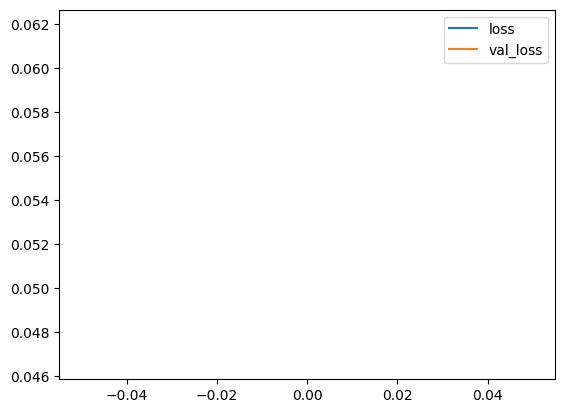

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## **Make Predictions**

In [21]:
input_text = vectorizer('You freaking suck! I am going to hit you.')





In [28]:
# Tokenize and vectorize the input text
input_text = ['You freaking suck! I am going to hit you.']  # Make sure it's in a list
input_text = vectorizer(input_text)
# Reshape the input to match the model's input shape
input_text = tf.expand_dims(input_text, -1)  # Add a dimension for batch size

# Generate predictions
res = model.predict(input_text)


1/1 [==============================] - 1s 765ms/step


In [29]:
(res > 0.5).astype(int)

array([[1, 1, 0, 1, 0, 1]])

In [30]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:

# Assuming batch_X is your input data
# Reshape batch_X to match the expected input shape of your model
batch_X_reshaped = batch_X.reshape((batch_X.shape[0], -1, 1))  # Assuming input features is 1

# Generate predictions
predictions = model.predict(batch_X_reshaped)

# Apply threshold (assuming binary classification)
binary_predictions = (predictions > 0.5).astype(int)


1/1 [==============================] - 0s 121ms/step


In [33]:
res.shape

(1, 6)

### **Evaluate Model**

In [34]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch

    # Reshape X_true to match the expected input shape of your model
    X_true_reshaped = X_true.reshape((X_true.shape[0], -1, 1))  # Assuming input features is 1

    # Make a prediction
    yhat = model.predict(X_true_reshaped)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    # Update the states of the metrics
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)


1/1 [==============================] - 0s 133ms/step


In [37]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.0332317091524601, Recall:0.7195752263069153, Accuracy:0.009027081541717052


### **Test and Gradio**

In [50]:
!pip install gradio

In [51]:
import tensorflow as tf
import gradio as gr

In [52]:
model.save('toxicity.h5')

In [53]:
model = tf.keras.models.load_model('toxicity.h5')

In [54]:
input_str = vectorizer('hey i freaken hate you!')

In [55]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 680ms/step


In [56]:
res

array([[0.5018727 , 0.5017489 , 0.49943343, 0.5001113 , 0.5001701 ,
        0.50052154]], dtype=float32)

In [57]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text



In [60]:
import gradio as gr  # Import Gradio
from gradio import Textbox  # Import individual components (assuming Gradio >= 2.0.0)



# Define the Gradio interface
interface = gr.Interface(
    fn=score_comment,
    inputs=[Textbox(lines=2, placeholder='Comment to score')],  # Pass a list of inputs
    outputs='text'
)




In [61]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0b871db936fb571751.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
